# Trabajo Práctico Semanal 9
Teoria de circuitos II

### Sandomir L Uriel

#### Inicializacion y plantilla de diseño:

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
from pylab import *
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import splane as tc2
from splane import plot_plantilla


def impz(b,a=1):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = sig.lfilter(b,a,impulse)
    subplot(211)
    stem(x, response)
    ylabel('Amplitude')
    xlabel(r'n (samples)')
#     xlim([600,800])
    title(r'Impulse response')

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla

# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

#### Filtro FIR

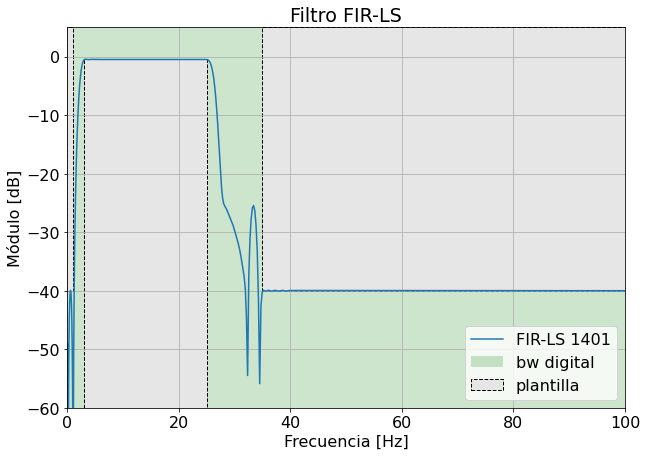

In [101]:
#Diseño filtro FIR

# #################################### FIRWIN2 ########################################

# #Regulacion de las frecuncias criticas
# frecs_firwin2 = np.array([0.0, 1.8 ,ws1 + 1.3,         wp1 -.7 ,     wp2 +1,  ws2 - 1,         nyq_frec   ]) / nyq_frec
# gains_firwin2 = np.array([-atenuacion, -60,-atenuacion, -ripple, -ripple,  -atenuacion, -atenuacion])
# gains_firwin2 = 10**(gains_firwin2/20)

# cant_coeficientes = 2401

# num_win = sig.firwin2(cant_coeficientes, frecs_firwin2, gains_firwin2 , window='blackmanharris' )

# #######################################################################################

#################################### FIRLS ########################################

#Regulacion de las frecuncias criticas
frecs_firls = np.array([0.0,      ws1+.4,         wp1,     wp2,  28, 32,   ws2,         nyq_frec   ])  / nyq_frec
gains_firls = np.array([-atenuacion*2, -atenuacion, -ripple, -ripple,-25,-40, -atenuacion, -atenuacion])
gains_firls = 10**(gains_firls/20)  

cant_coeficientes = 1401

num_win = sig.firls(cant_coeficientes, frecs_firls, gains_firls)

#######################################################################################

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-LS {:d}'.format(num_win.shape[0]))

plt.title('Filtro FIR-LS')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)


Se logra un filtro equiripple de tipo FIR 

#### Filtro IIR


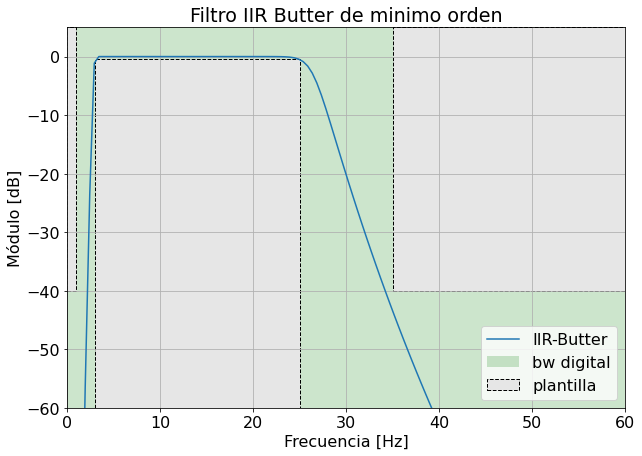

(15, 6)

In [3]:
# # DISEÑO DE FILTRO IIR

# Butter minimo orden
iir_butter_sos = sig.iirdesign(wp = np.array([wp1,wp2])/nyq_frec, ws = np.array([ws1,ws2])/nyq_frec, gpass = ripple, gstop = atenuacion, analog=False, ftype='butter', output='sos')

w, iir_butter = sig.sosfreqz(iir_butter_sos, worN = 1024)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20*np.log10(np.abs(iir_butter)), label='IIR-Butter' )

plt.title('Filtro IIR Butter de minimo orden')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

Nmin = iir_butter_sos.shape
Nmin

Se obtiene una muy buena respuesta en modulo y una planicidad muy atractiva en la banda de paso a costa de un orden relativamente alto.
<br><br>

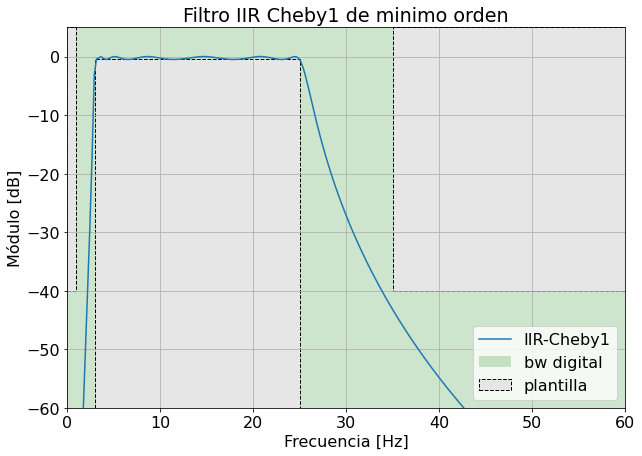

(7, 6)

In [4]:
# Cheby 1 de minimo orden

iir_cheby1_sos = sig.iirdesign(wp = np.array([wp1,wp2])/nyq_frec, ws = np.array([ws1,ws2])/nyq_frec, gpass = ripple, gstop = atenuacion, analog=False, ftype='cheby1', output='sos')

w, iir_cheby1 = sig.sosfreqz(iir_cheby1_sos, worN = 2048)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20*np.log10(np.abs(iir_cheby1)), label='IIR-Cheby1' )

plt.title('Filtro IIR Cheby1 de minimo orden')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

Nmin = iir_cheby1_sos.shape
Nmin

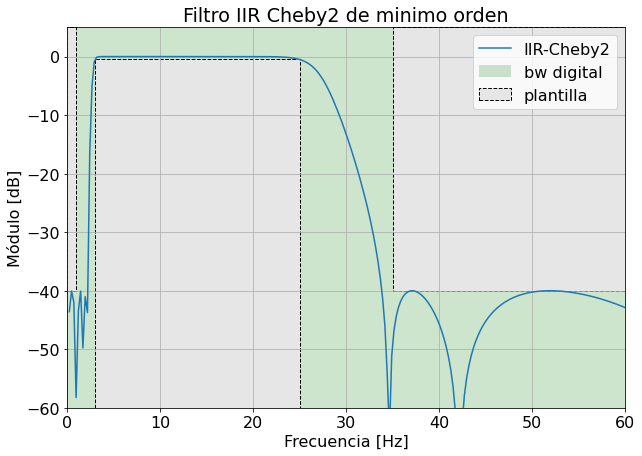

(7, 6)

In [76]:
# Cheby 2 de minimo orden

iir_cheby2_sos = sig.iirdesign(wp = np.array([wp1,wp2])/nyq_frec, ws = np.array([ws1,ws2])/nyq_frec, gpass = ripple, gstop = atenuacion, analog=False, ftype='cheby2', output='sos')

wc2, iir_cheby2 = sig.sosfreqz(iir_cheby2_sos, worN = 2048)

# renormalizo el eje de frecuencia
wc2 = wc2 / np.pi * nyq_frec

plt.plot(wc2, 20*np.log10(np.abs(iir_cheby2)), label='IIR-Cheby2' )

plt.title('Filtro IIR Cheby2 de minimo orden')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

Nmin = iir_cheby2_sos.shape
Nmin

Para el caso de los chebys, obtenemos filtros que cumplen con la plantilla de un orden minimo igual para ambos casos, sin embargo nos interesa que las amplitudes de las señales con frecuencias dentro de la BW se deformen lo menos posible, por lo que el Chebyshev 2 que nos brinda un ripple mas uniforme, nos proporciona una mejor respuesta para esta aplicacion.
<br><br>

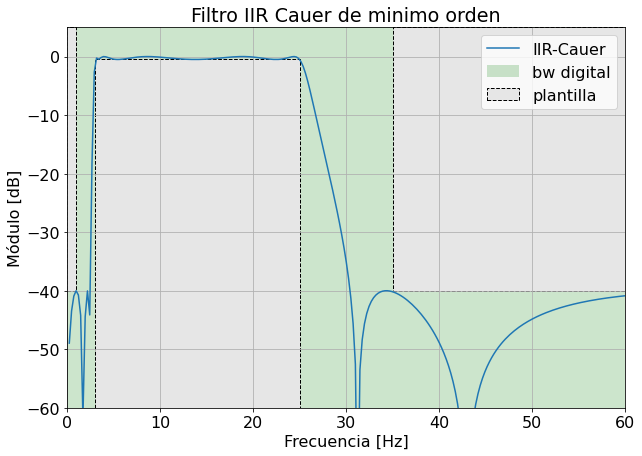

(5, 6)

In [6]:
# Cauer de minimo orden

iir_cauer_sos = sig.iirdesign(wp = np.array([wp1,wp2 ])/nyq_frec, ws = np.array([ws1,ws2])/nyq_frec, gpass = ripple, gstop = atenuacion, analog=False, ftype='ellip', output='sos')

w, iir_cauer = sig.sosfreqz(iir_cauer_sos, worN = 2048)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20*np.log10(np.abs(iir_cauer)), label='IIR-Cauer' )

plt.title('Filtro IIR Cauer de minimo orden')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

Nmin = iir_cauer_sos.shape
Nmin

Observamos que para un filtro del tipo Cauer, se cumple la plantilla para un orden menor a costa de tener ripple uniforme.
<br><br>


<br>
Para nuestra aplicacion, donde nos interesa evitar una deformacion sobre banda de paso, es buena idea elegir un filtro que nos brinde un ripple uniforme a un orden tan bajo como sea posible. Por esta razon, nos quedamos con el Chebyshev2 para el IIR y con el FIR por cuadrados minimos.

### Respuesta en frecuencia de los filtros

#### IIR : Chebyshev2 de orden 7

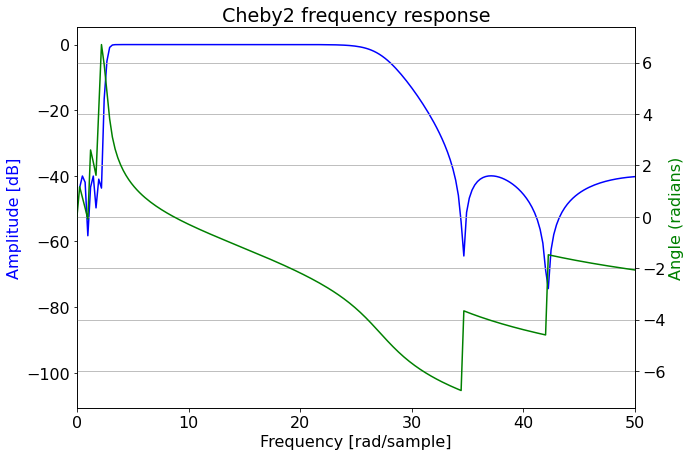

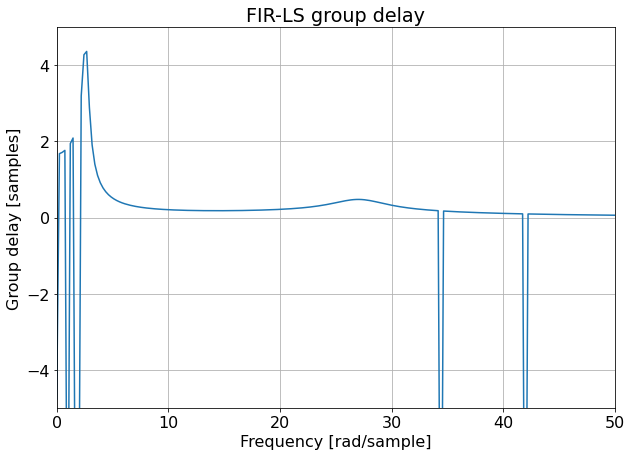

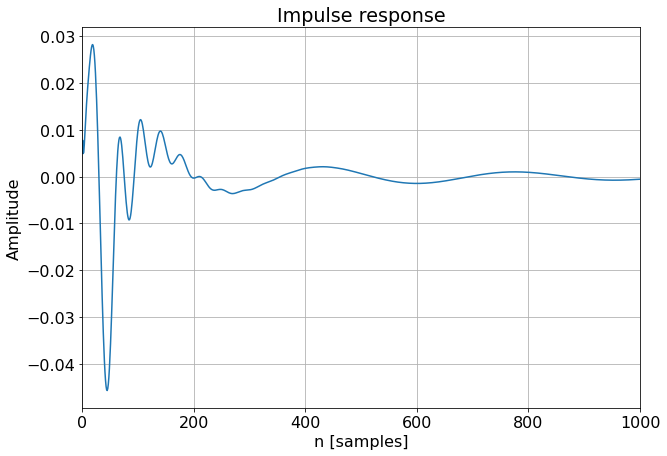

In [151]:
fig, ax1 = plt.subplots()
ax1.set_title('Cheby2 frequency response')
ax1.plot(wc2, 20 * np.log10(abs(iir_cheby2)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(iir_cheby2))
ax2.plot(wc2, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
ax1.set_xlim([0,50])
ax2.set_xlim([0,50])
plt.show()

gd = -np.diff(angles) / np.diff(wc2)
plt.title('FIR-LS group delay')
n = np.arange(len(gd))
plt.plot(wc2[:-1], gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.xlim([0,50])
plt.ylim([-5,5])
plt.show()

l = len(iir_cheby2)
impulse = repeat(0.,l); impulse[0] =1.
x = arange(0,l)
response = sig.sosfilt(iir_cheby2_sos, impulse)
plt.plot(x, response)
plt.ylabel('Amplitude')
plt.xlabel('n [samples]')
plt.title('Impulse response')
plt.grid()
plt.xlim([0,1000])
plt.show()


#### FIR : Least Squares Filter N=1401

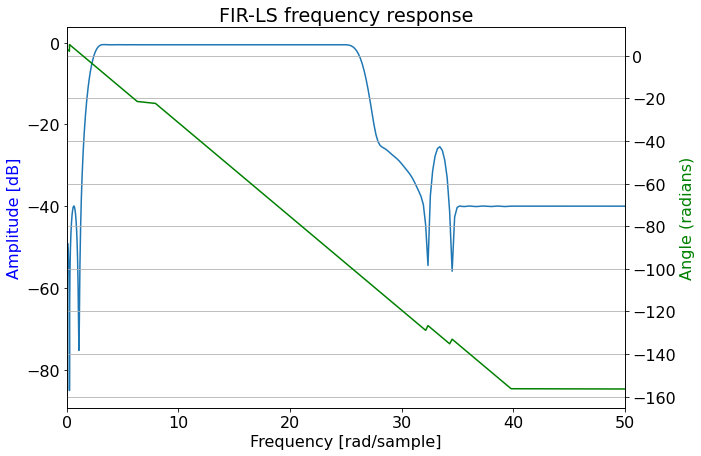

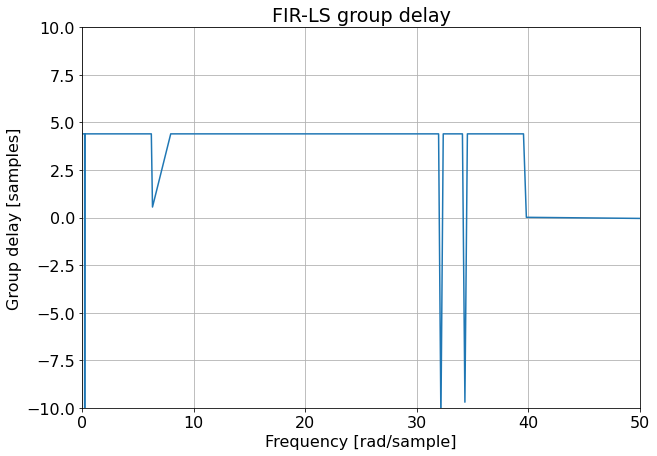

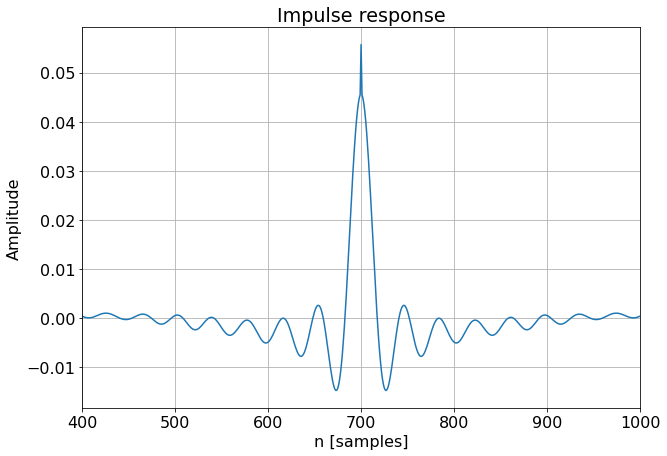

In [158]:
# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec
#

fig, ax1 = plt.subplots()
ax1.set_title('FIR-LS frequency response')
ax1.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-LS {:d}'.format(num_win.shape[0]))
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(hh_win))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
ax1.set_xlim([0,50])
ax2.set_xlim([0,50])
plt.show()

gd = -np.diff(angles) / np.diff(w)
plt.title('FIR-LS group delay')
n = np.arange(len(gd))
plt.plot(w[:-1], gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.xlim([0,50])
plt.ylim([-10,10])
plt.show()

l = len(num_win)
impulse = repeat(0.,l); impulse[0] =1.
x = arange(0,l)
response = sig.lfilter(num_win,den, impulse)
plt.plot(x, response)
plt.ylabel('Amplitude')
plt.xlabel('n [samples]')
plt.title('Impulse response')
plt.grid()
plt.xlim([400,1000])
plt.show()

### Implementacion (Parte2)


In [182]:
# IIR
ECG_f_iir = sig.sosfiltfilt(iir_cheby2_sos, ecg_one_lead)

# FIR
ECG_f_fir = sig.filtfilt(num_win, den, ecg_one_lead)

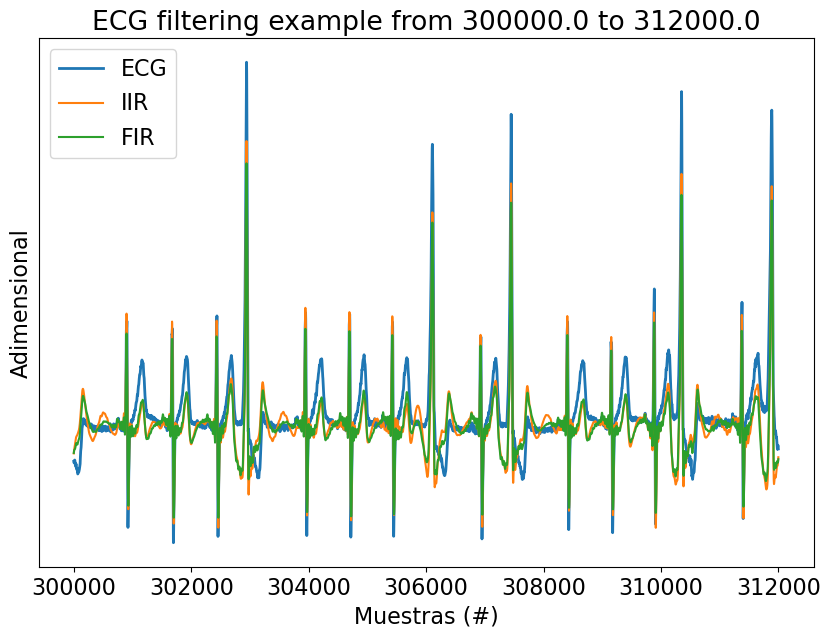

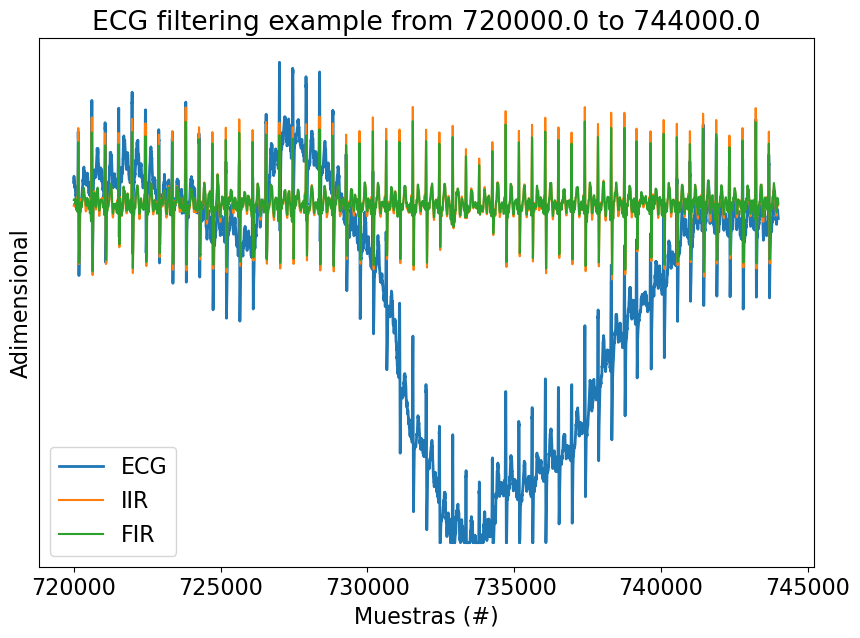

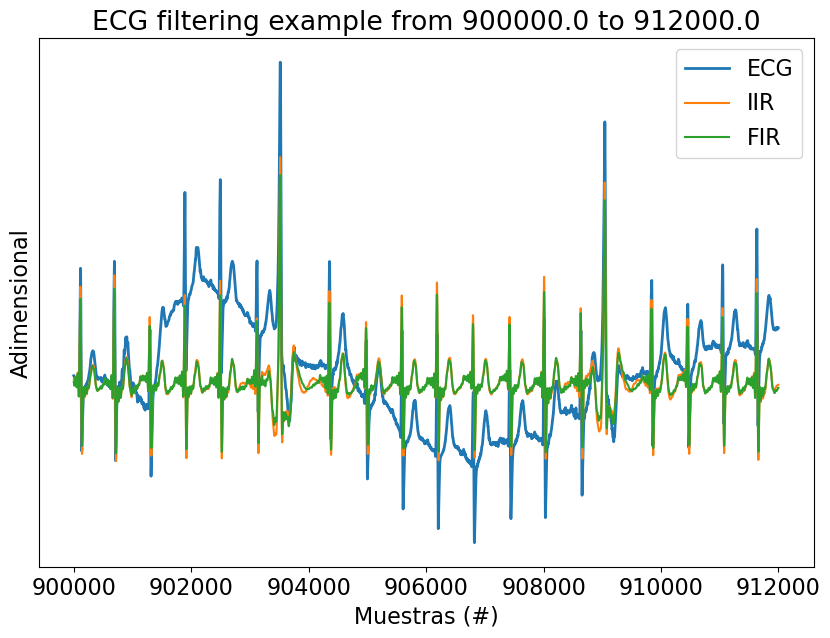

In [183]:
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 0


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IIR')
    plt.plot(zoom_region, ECG_f_fir[zoom_region + demora], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

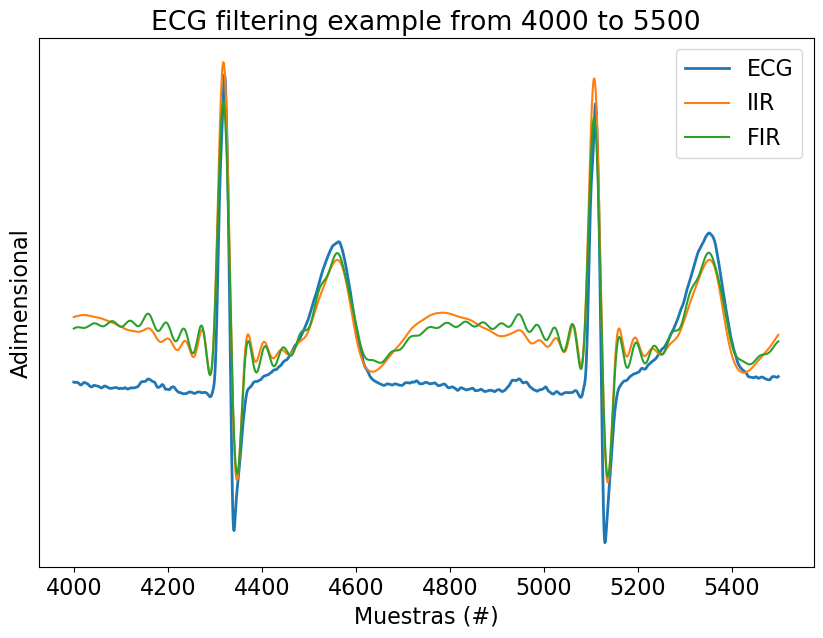

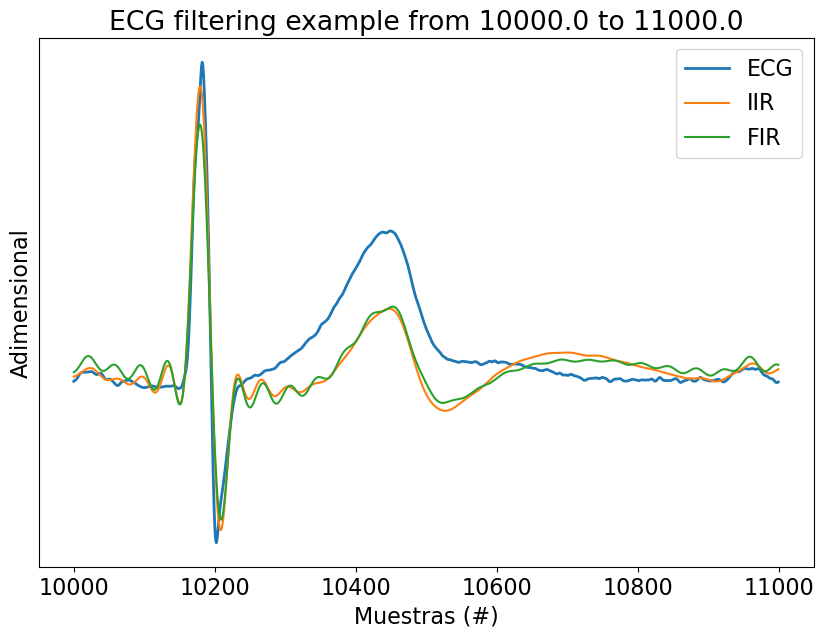

In [184]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IIR')
    plt.plot(zoom_region, ECG_f_fir[zoom_region + demora], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()